In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from astroExplain.spectra.explanation import TellMeWhy
from anomaly.constants import GALAXY_LINES
from anomaly.utils import line_width_from_velocity

In [2]:
# directories for data
bin_id = "bin_03"
user = "/home/edgar"
work_directory = f"{user}/spectra/0_01_z_0_5_4_0_snr_inf"
model = "256_128_64/latent_12/"
metric = "mse_filter_250kms_noRel100"
# metric = "mse_filter_250kms_noRel97"
# metric = "mse_noRel97"
# metric = "mse_filter_250kms_rel100"
# metric = "mse_filter_250kms_rel97"
# metric = "mse_rel100"
# metric = "mse_rel97"
data_directory = (
    f"{work_directory}/{bin_id}/"
    f"explanation/{model}/{metric}"
)

In [3]:
wave = np.load(f"{work_directory}/wave_spectra_imputed.npy")
anomalies = np.load(f"{data_directory}/top_anomalies.npy")
df_anomalies = pd.read_csv(
    f"{data_directory}/top_anomalies.csv.gz",
    index_col="specobjid"
)

# load mean and median spectra
median_spectrum = np.load(
    f"{work_directory}/{bin_id}/median_spectrum.npy"
)
mean_spectrum = np.load(
    f"{work_directory}/{bin_id}/average_spectrum.npy"
)

# load the weights

explanation_weights = np.load(f"{data_directory}/weights_all_abs.npy")

In [15]:
explanation_weights.min(), explanation_weights.max()

(0.0, 1.0)

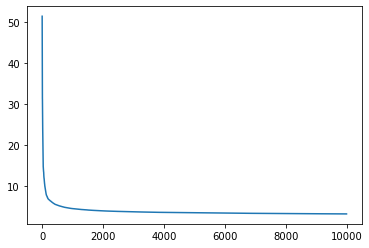

In [5]:
# sort scores in descending order in place in the df
df_anomalies.sort_values(by="score", ascending=False, inplace=True)
plt.plot(df_anomalies["score"].to_numpy())

## Analyze clusters among anomalies
The clustering approach can help to gain insight into the model by grouping the anomalous spectra into clusters based on their similarity in terms of the weights assigned by the LIME algorithm. This can help identify patterns or trends in the explanations that may not be immediately apparent from the weights alone.

For example, certain clusters might have higher explanation weights for certain wavelength ranges, or certain clusters have higher explanation weights overall. This can help to understand which features of the spectra are most important for the model's predictions, and can potentially uncover new scientific insights.

Additionally, by plotting the mean spectrum and mean explanation weights for each cluster, I can get a sense of how the model is using different features of the spectra to make its predictions, and identify any patterns or trends in the model's behavior that may be relevant to the anomaly detection task.

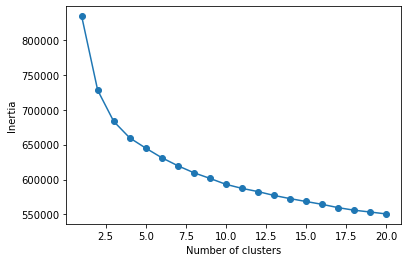

In [6]:
# Create a list to store the evaluation metric values
inertias = []
n_clusters = range(1, 21)
# Fit the k-means model with a range of values for the number of clusters
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=0)
    kmeans.fit(explanation_weights)
    inertias.append(kmeans.inertia_)
    print(f"n: {n}, inertia: {kmeans.inertia_}", end="\r")

# Plot the evaluation metric values against the number of clusters
plt.plot(n_clusters, inertias, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


In [7]:
inertias

[833943.2602730264,
 727926.1132351172,
 683321.9673371279,
 659684.5872719844,
 645002.7341693024,
 631293.9193916908,
 619815.4751060379,
 609775.2898360823,
 601709.0602571684,
 593191.6876122367,
 587393.0482940959,
 582788.958215704,
 577278.8676433794,
 572721.3333451019,
 568581.2664829522,
 564528.2748703314,
 559797.3189056221,
 556110.2561988499,
 553509.6570276804,
 550766.5504247044]

In [8]:
# Use k-means clustering to group the spectra
kmeans = KMeans(n_clusters=10, random_state=0)
cluster_labels = kmeans.fit_predict(explanation_weights)

Number of spectra in cluster 0: 1114
Number of spectra in cluster 1: 1534
Number of spectra in cluster 2: 1598
Number of spectra in cluster 3: 644
Number of spectra in cluster 4: 524
Number of spectra in cluster 5: 817
Number of spectra in cluster 6: 575
Number of spectra in cluster 7: 1100
Number of spectra in cluster 8: 1148
Number of spectra in cluster 9: 946


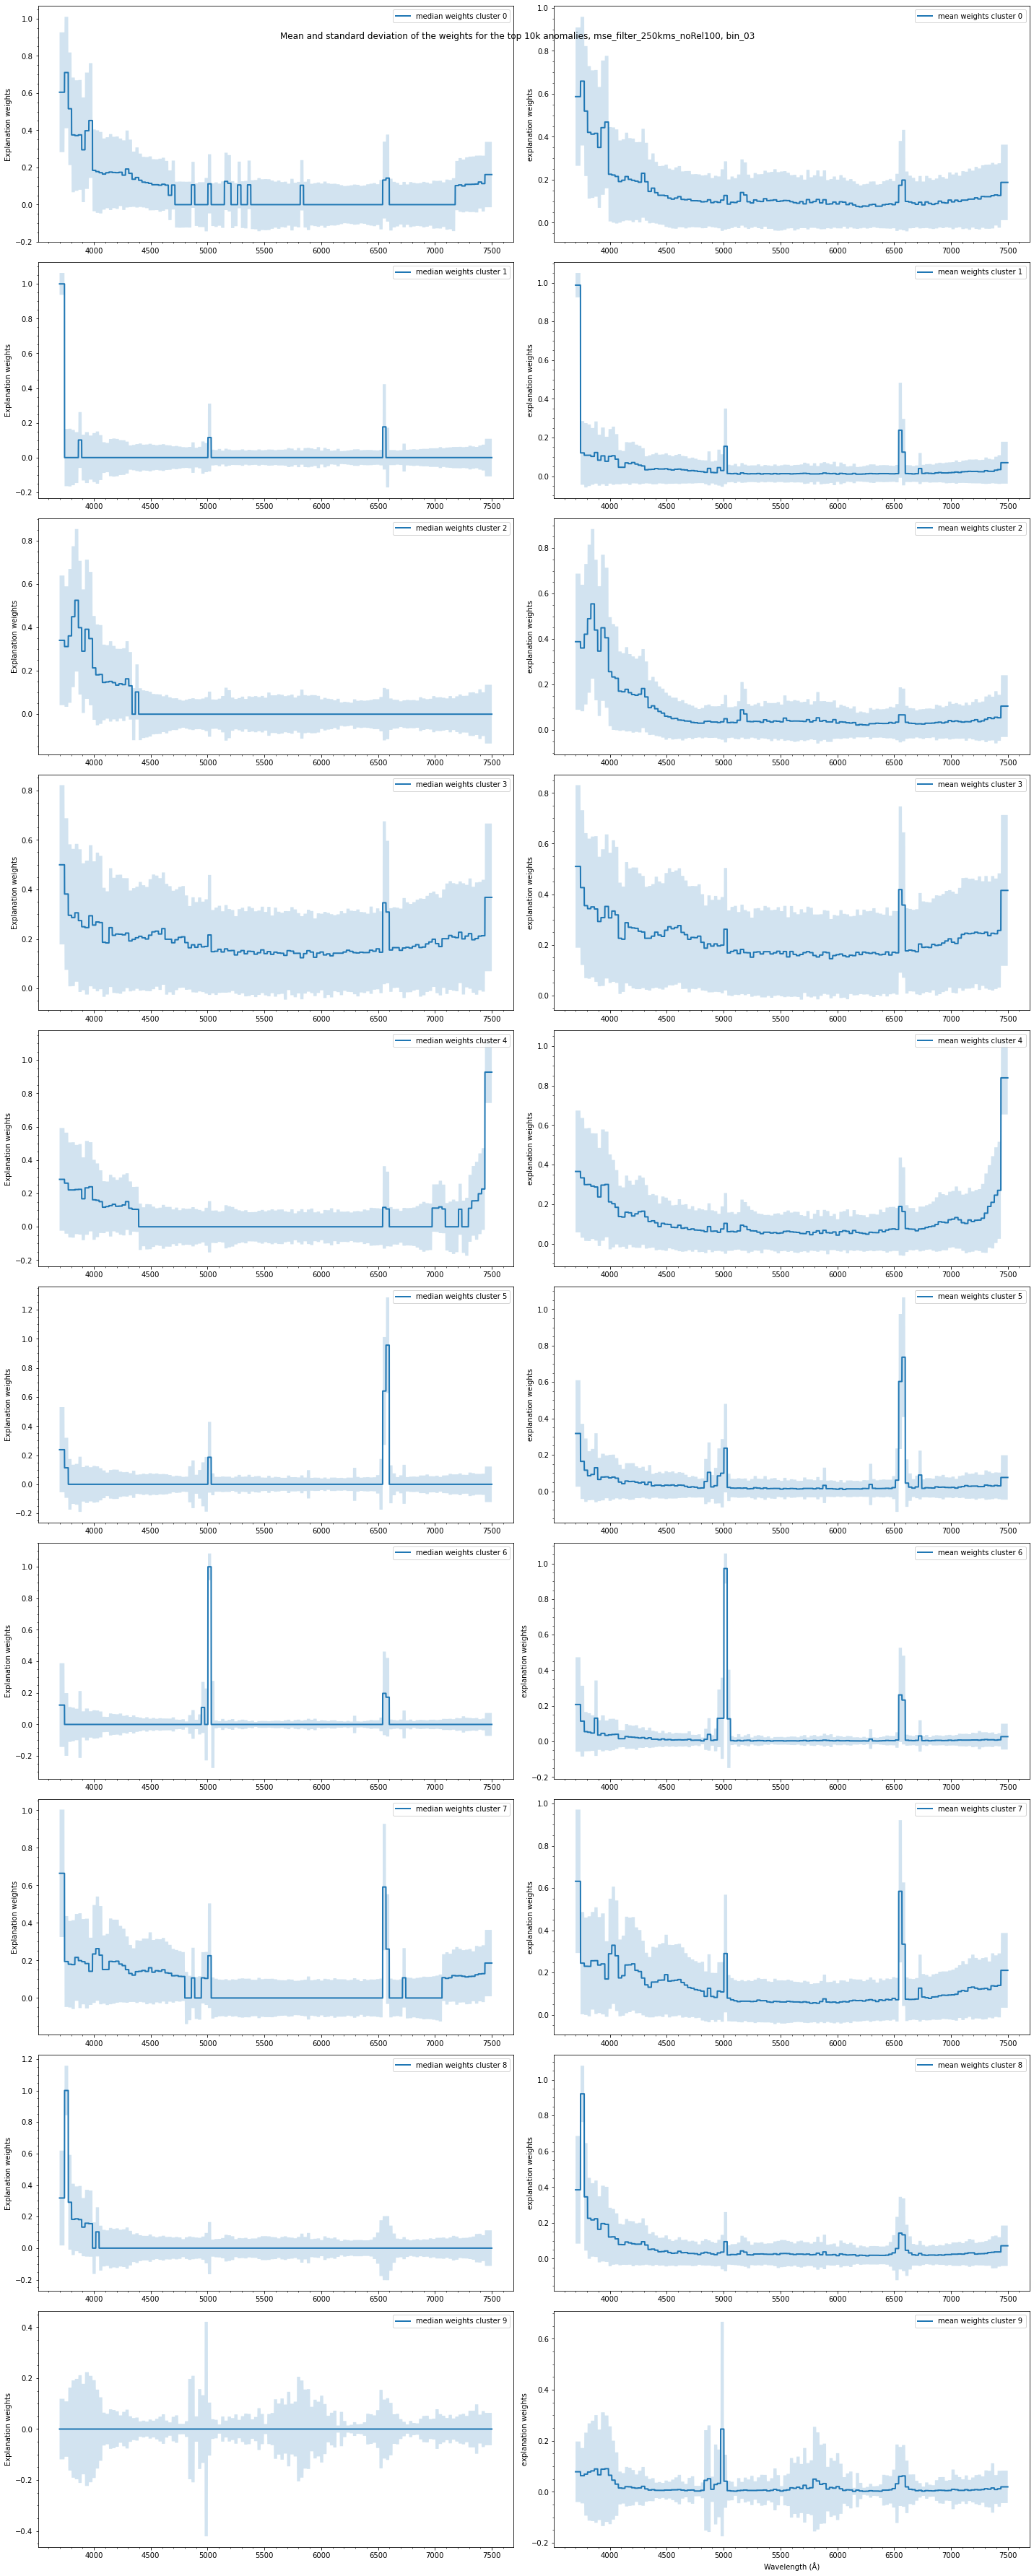

In [16]:
# Create a figure with a grid of subplots
fig, axs = plt.subplots(
    kmeans.n_clusters, 2, tight_layout=True,
    sharex=False, sharey=False,
    figsize=(20, 50)
)

# minor ticks on
for ax in axs.flat:
    ax.minorticks_on()

# Add a title to the figure
fig.suptitle(
    f"Mean and standard deviation of the weights for the top 10k anomalies, {metric}, {bin_id}",
    fontsize=12
)

# Loop over the clusters
for i in range(kmeans.n_clusters):
    # Select the spectra in the cluster
    cluster_anomalies = anomalies[cluster_labels == i]
    cluster_weights = explanation_weights[cluster_labels == i]

    # Compute summary statistics for the explanations in the cluster
    cluster_median_weights = np.median(cluster_weights, axis=0)
    cluster_mean_weights = np.mean(cluster_weights, axis=0)
    cluster_std_weights = np.std(cluster_weights, axis=0)

    # Plot the mean and standard deviation for the cluster
    axs[i, 0].plot(
        wave, cluster_median_weights, linewidth=2,
        label=f"median weights cluster {i}"
    )

    axs[i, 0].fill_between(
        wave, cluster_median_weights - cluster_std_weights,
        cluster_median_weights + cluster_std_weights, alpha=0.2
    )

    axs[i, 0].legend()
    axs[i, 0].set_ylabel('Explanation weights')
    
    axs[i, 1].plot(
        wave, cluster_mean_weights, linewidth=2,
        label=f"mean weights cluster {i}"
    )
    axs[i, 1].legend()

    axs[i, 1].fill_between(
        wave, cluster_mean_weights - cluster_std_weights,
        cluster_mean_weights + cluster_std_weights, alpha=0.2
    )
    
    axs[i, 1].set_ylabel('explanation weights')

    # Print the number of spectra in the cluster
    print(f'Number of spectra in cluster {i}: {len(cluster_anomalies)}')

# Label the x-axis and show the figure
plt.xlabel('Wavelength (Å)')
plt.show()

#save figure to pdf in data directory

fig.savefig(
    f"{data_directory}/cluster_mean_std_weights_top_10k_anomalies.pdf"
)

## Analyze emission lines

In [22]:
# Retrieve the line widths for each line using the line_width_from_velocity function
line_widths = {}

for line, wavelength in GALAXY_LINES.items():
    line_width = line_width_from_velocity(300, wavelength)
    line_widths[line] = line_width

# Create an array to store the explanations weights for each line

# weights_per_line = np.empty((anomalies.shape[0], len(line_widths)))

line_weights = {}

for line, line_width in line_widths.items():
    # Retrieve the explanations weights for the wavelengths within the line width
    line_wavelength = GALAXY_LINES[line]

    line_mask = (wave > line_wavelength - line_width) & (wave < line_wavelength + line_width)

    # wave_region = wave[line_mask]

    line_weights[line] = (explanation_weights[:, line_mask], line_mask)

In [23]:
# Use a k-means clustering for each array in the list line_weights to cluster the explanations weights for each line in 10 clusters

n_clusters = 10

kmeans_per_line = {}

for line, (line_w, line_mask) in line_weights.items():
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(line_w)

    kmeans_per_line[line] = (kmeans, line_mask)


[1167, 5796, 192, 491, 33, 1159, 302, 748, 98, 14]


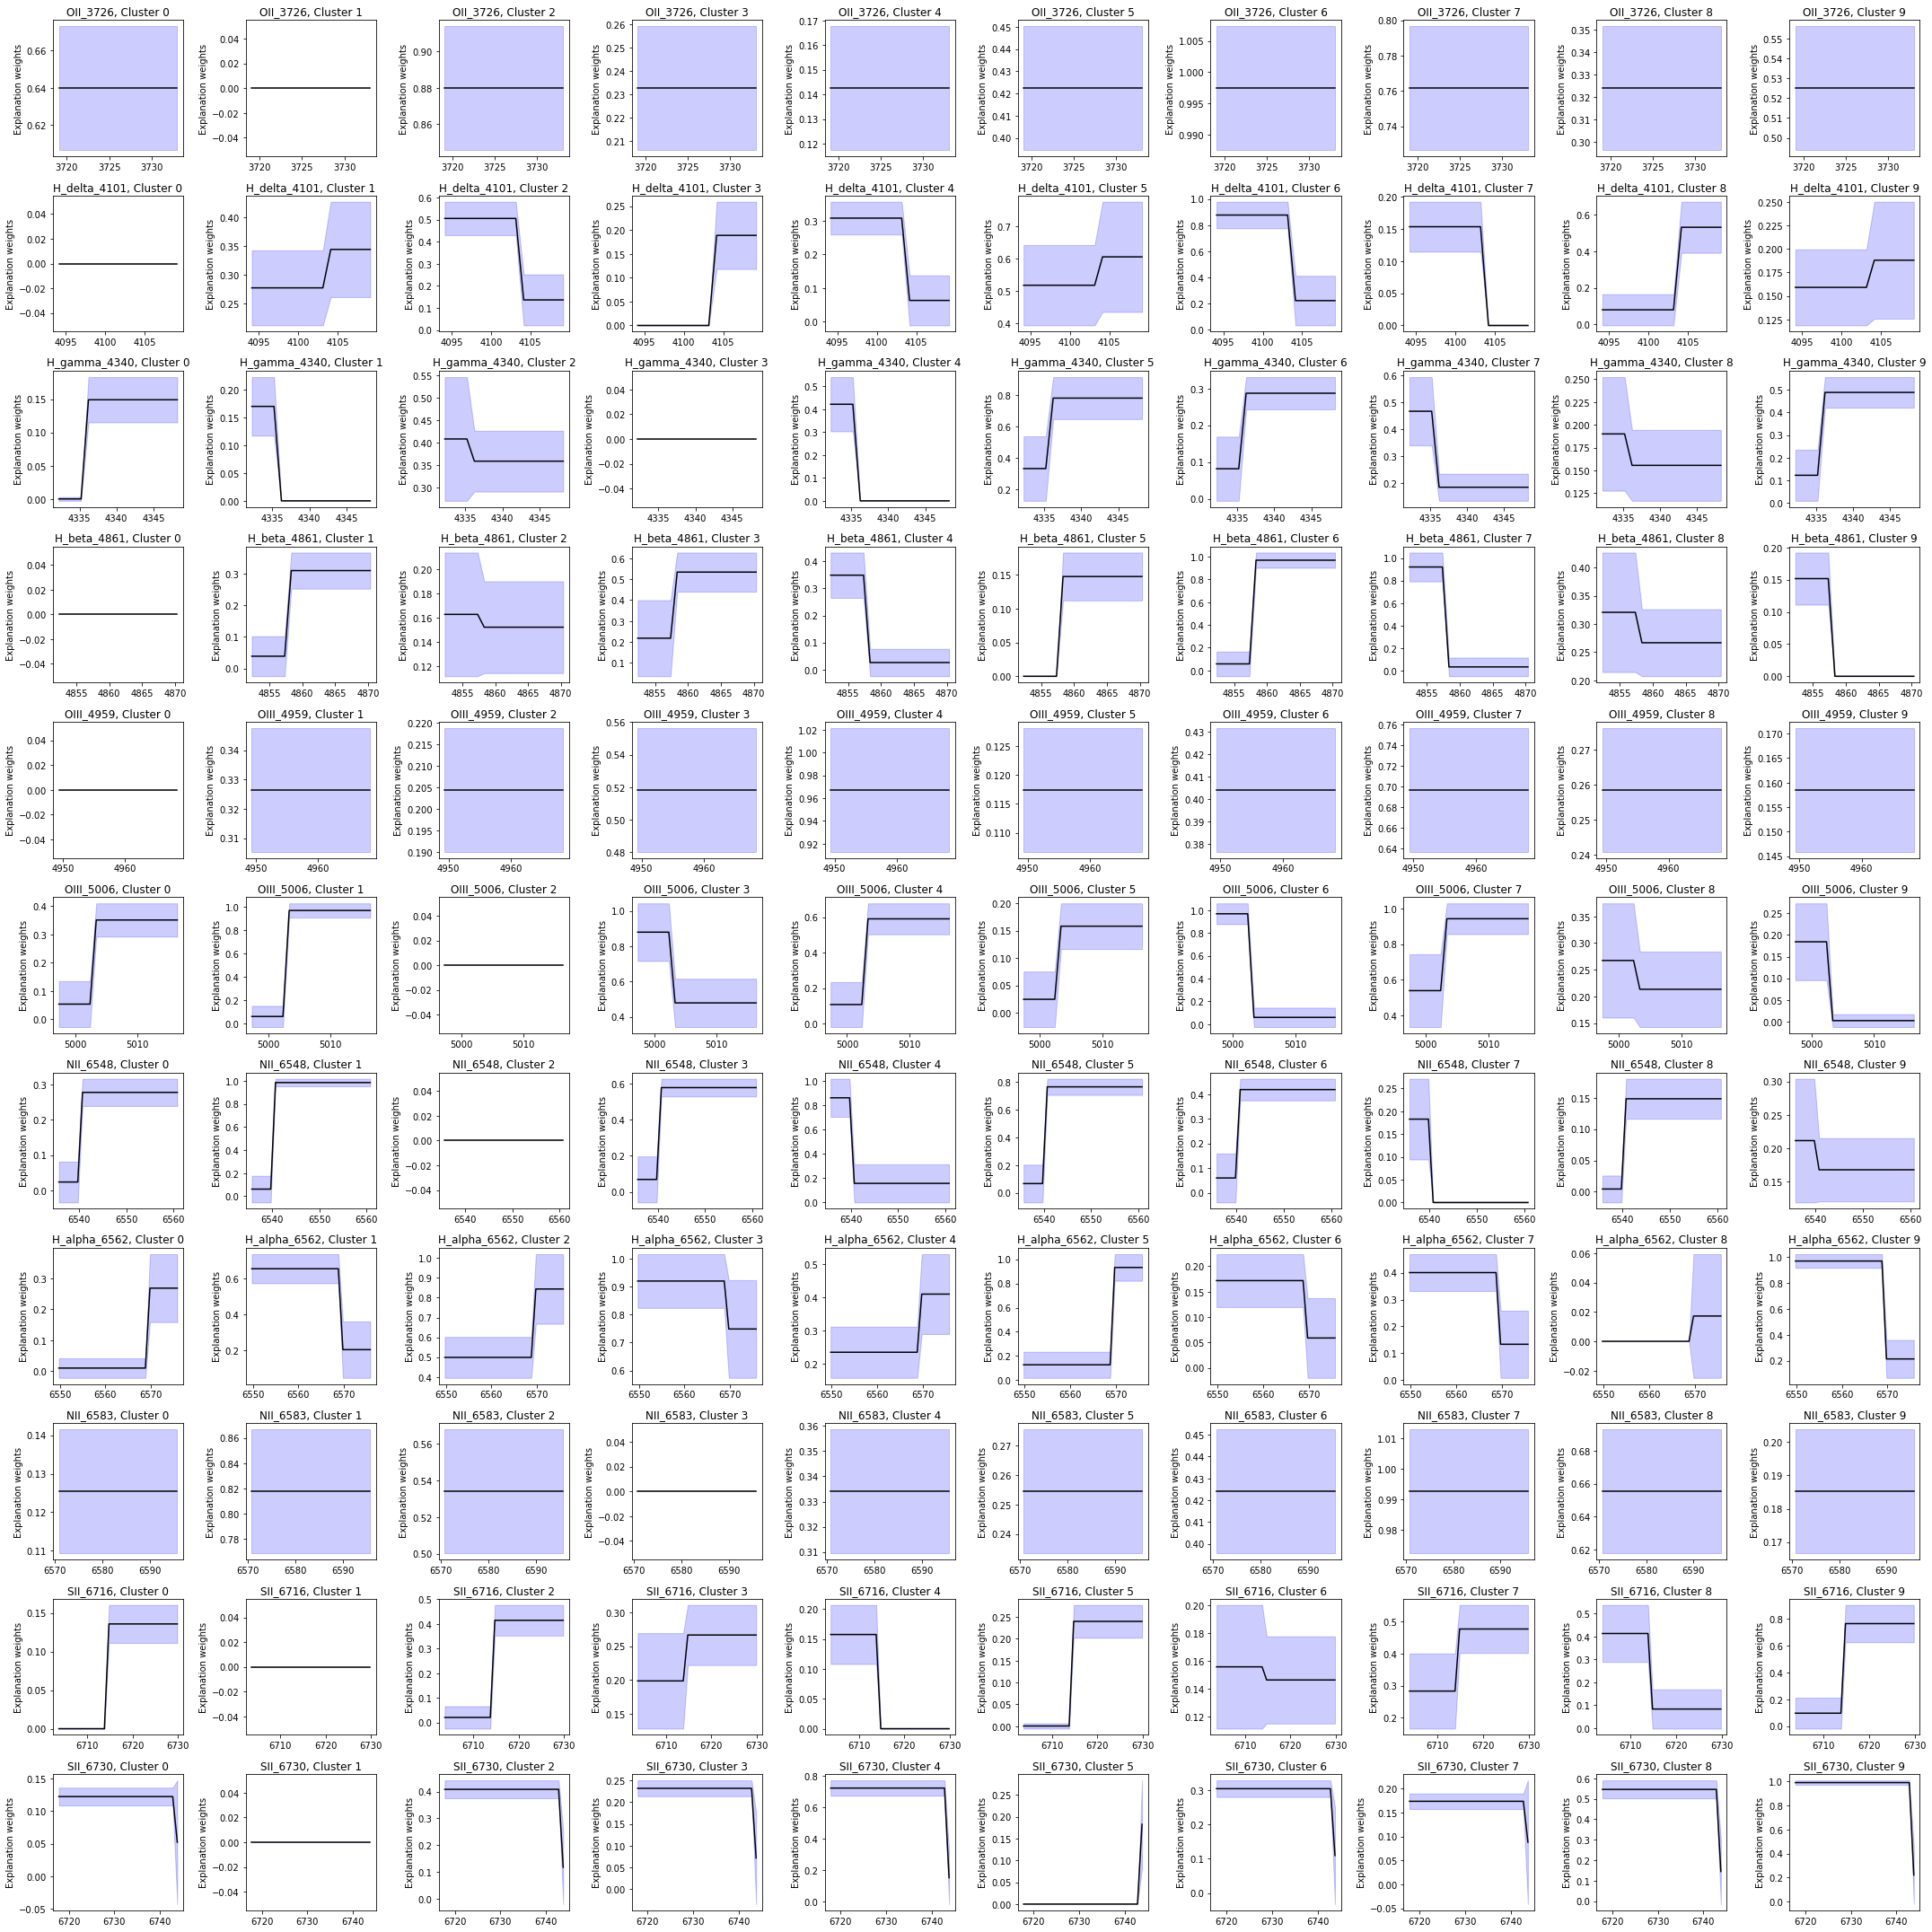

In [25]:
# Set up a grid of subplots
fig, axs = plt.subplots(
    nrows=len(kmeans_per_line), ncols=n_clusters,
    tight_layout=True,
    figsize=(30, 30)
)

# Loop through each line in the dictionary of k-means models
for i, (line, (kmeans, line_mask)) in enumerate(kmeans_per_line.items()):
    # Get the cluster labels for the current line
    cluster_labels = kmeans.predict(line_weights[line][0])

    # Compute the mean and standard deviation of the weights and anomalies for each cluster
    mean_weights = []
    std_weights = []
    # mean_anomalies = []
    # std_anomalies = []

    n_spectra_per_cluster = []

    for j in range(n_clusters):
    
        mask = cluster_labels == j
        n_spectra_per_cluster.append(np.sum(mask))

        mean_weights.append(np.mean(line_weights[line][0][mask], axis=0))
        std_weights.append(np.std(line_weights[line][0][mask], axis=0))
    
        # mean_anomalies.append(
        #     np.mean(anomalies[:, line_mask][mask], axis=0)
        # )
        # std_anomalies.append(
        #     np.std(anomalies[:, line_mask][mask], axis=0)
        # )

    # Plot the mean spectrum and mean explanation weights for each cluster

    wave_region = wave[line_mask]

    # for n in range(n_clusters):

    #     axs[i, 0].plot(wave_region, mean_weights[n], label=f'{n}')

    # axs[i, 0].set_ylabel('Weights')
    # axs[i, 0].legend()
    
    # Add a plot for each cluster's mean spectrum to the remaining columns
    
    for j in range(n_clusters):

        axs[i, j].plot(wave_region, mean_weights[j], c='black')
        axs[i, j].set_ylabel('Explanation weights')
        axs[i, j].set_title(f'{line}, Cluster {j}')
        axs[i, j].fill_between(
            wave_region,
            mean_weights[j] - std_weights[j],
            mean_weights[j] + std_weights[j],
            alpha=0.2,
            color='blue'
        )
print(n_spectra_per_cluster)

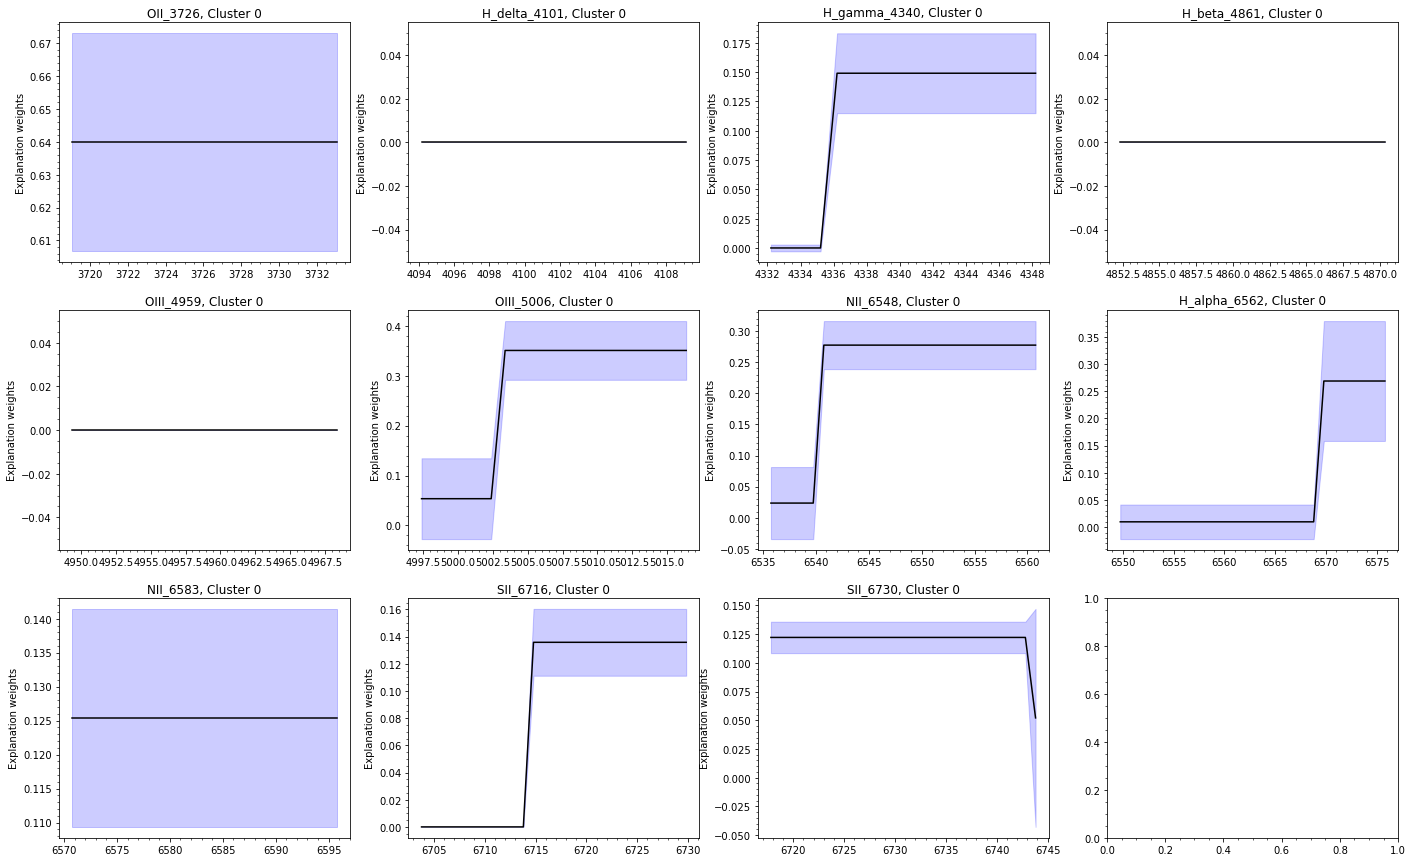

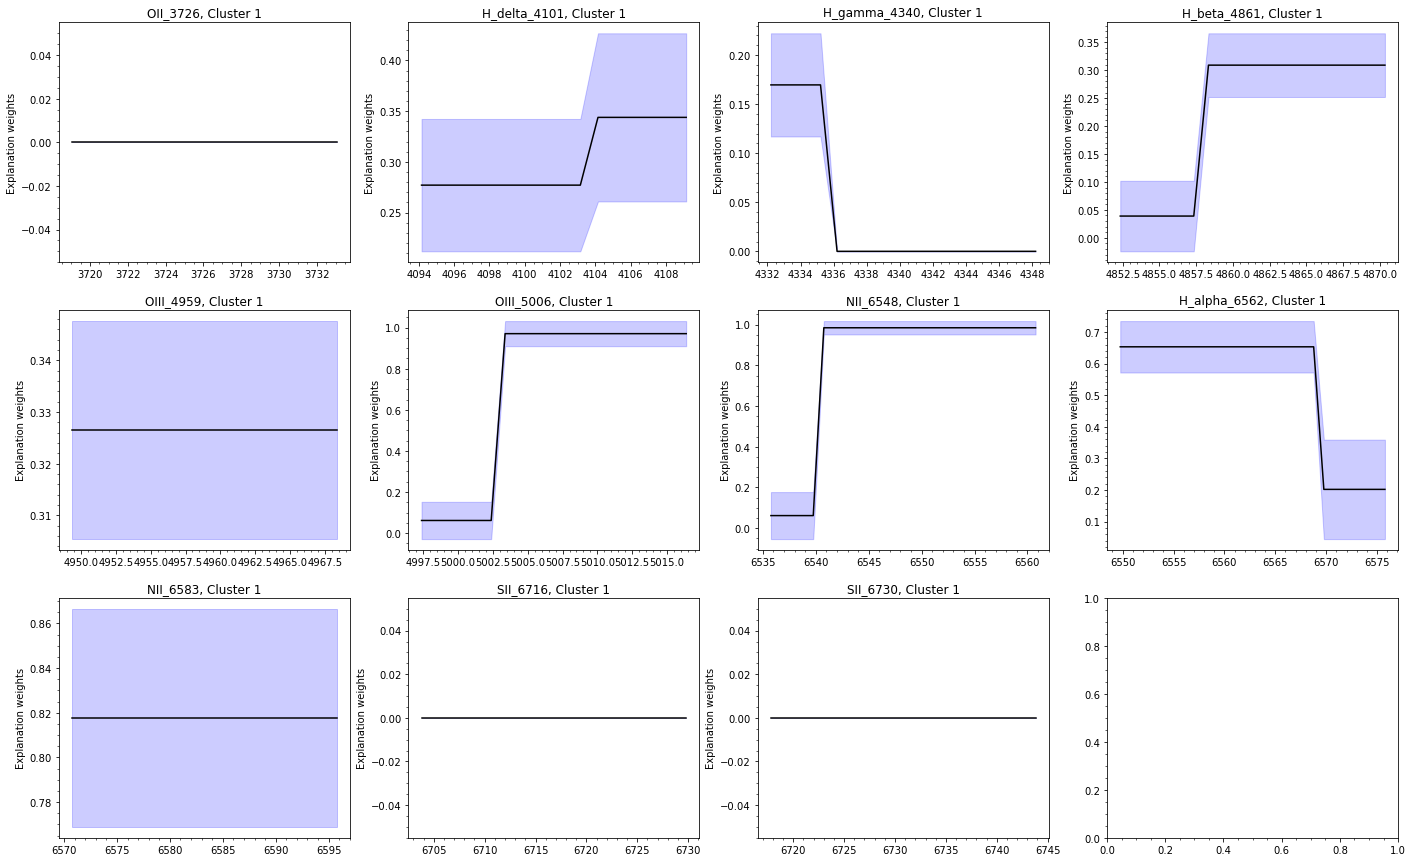

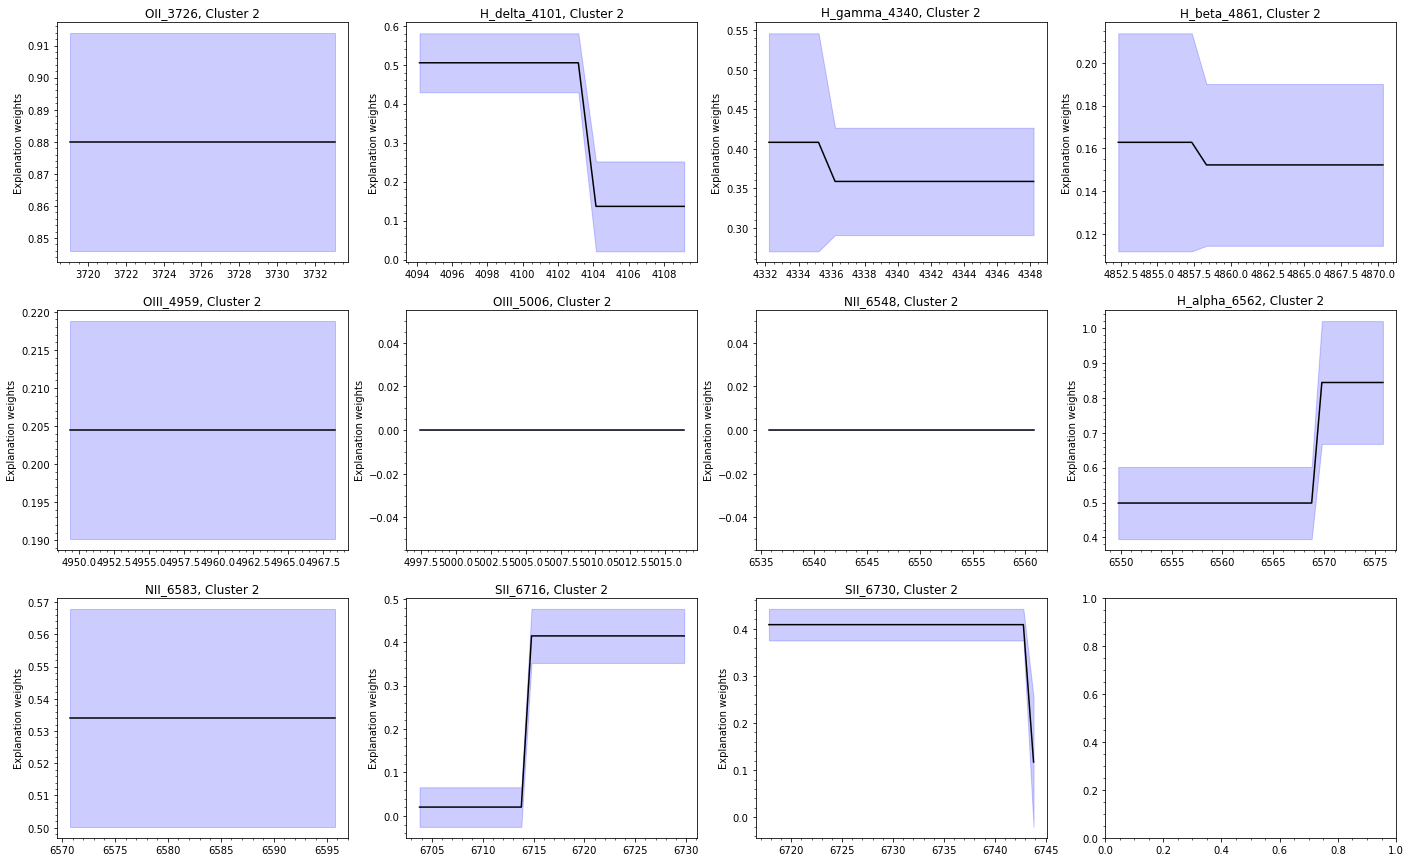

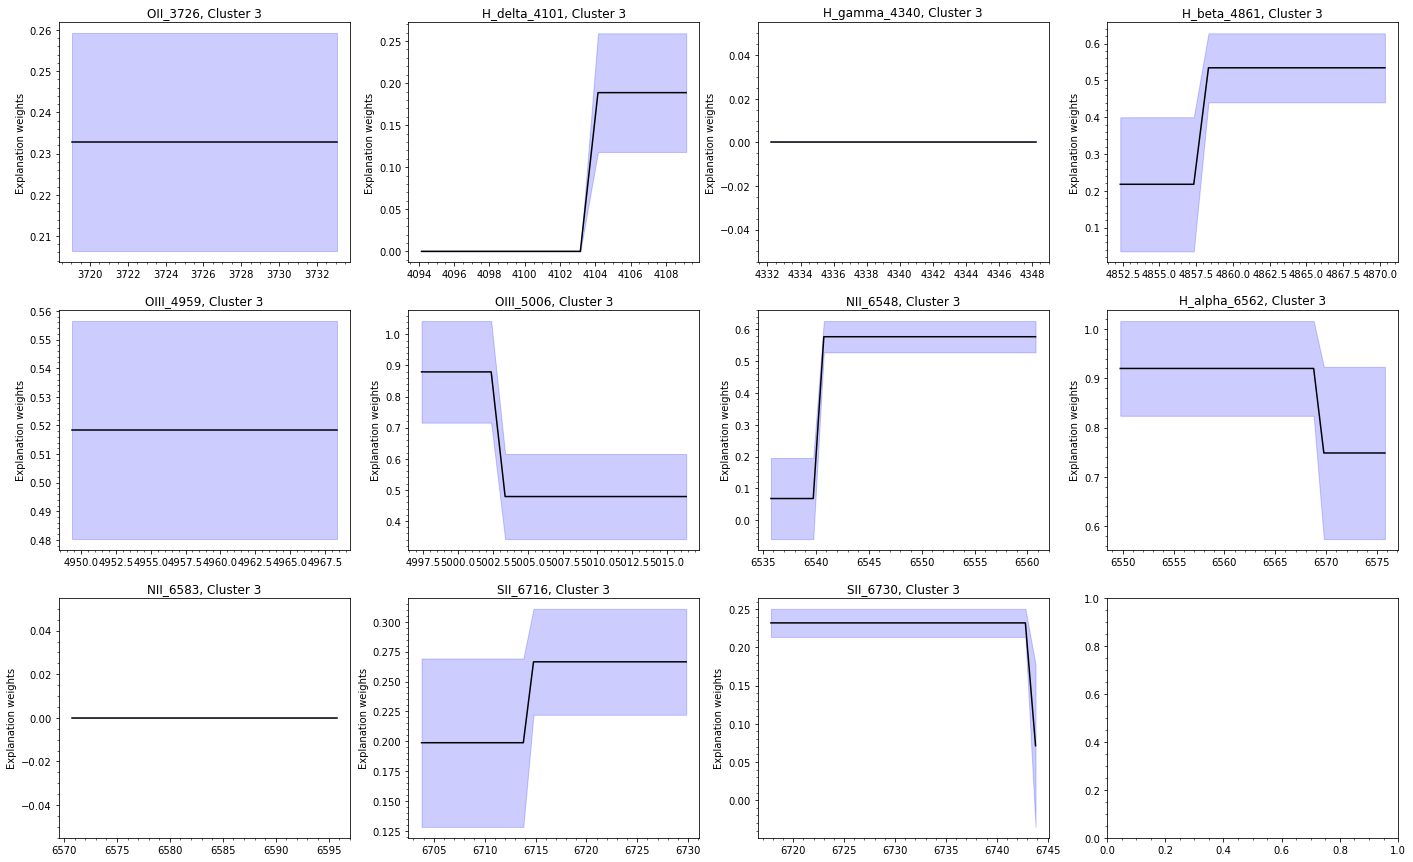

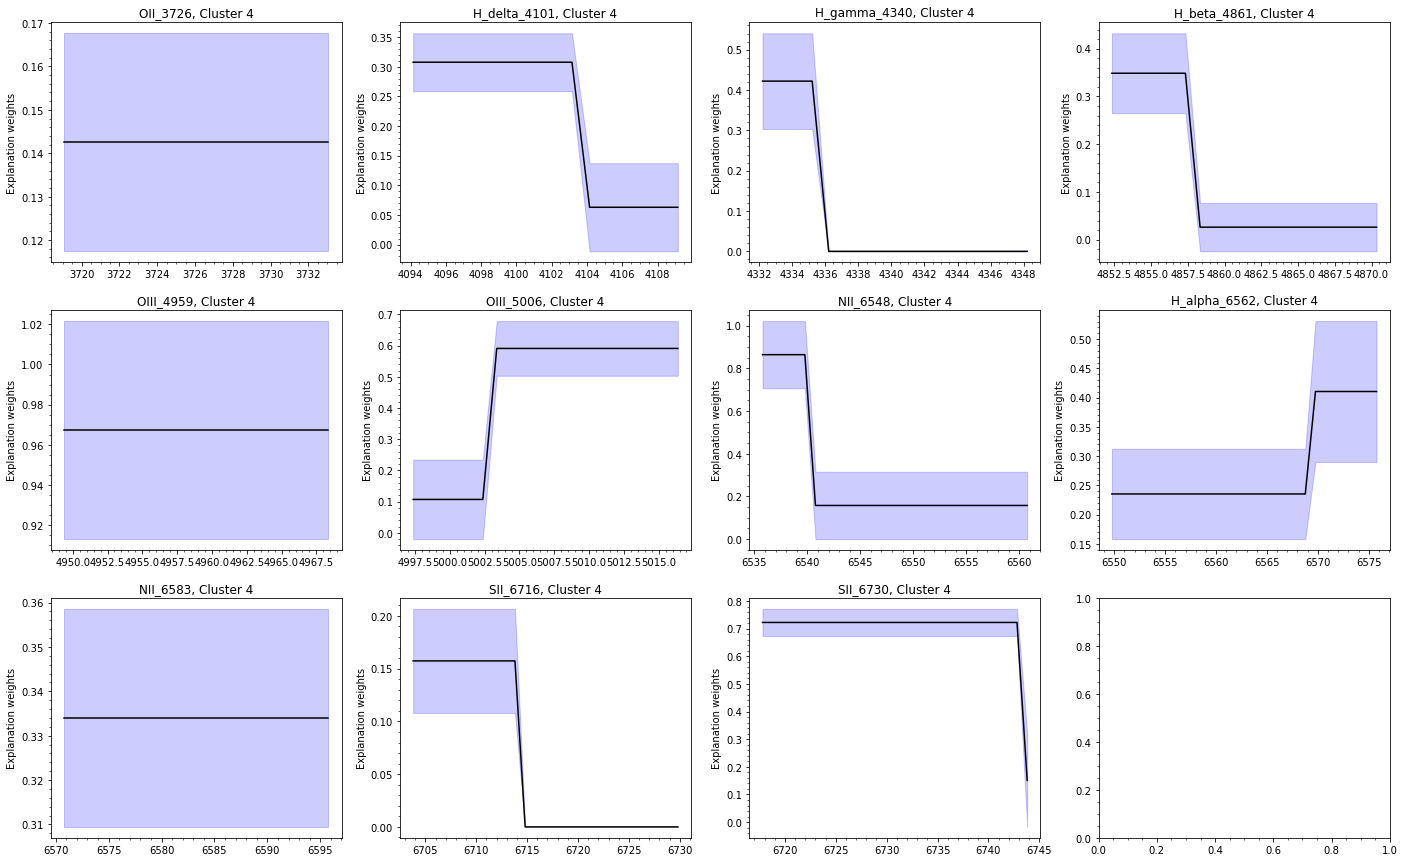

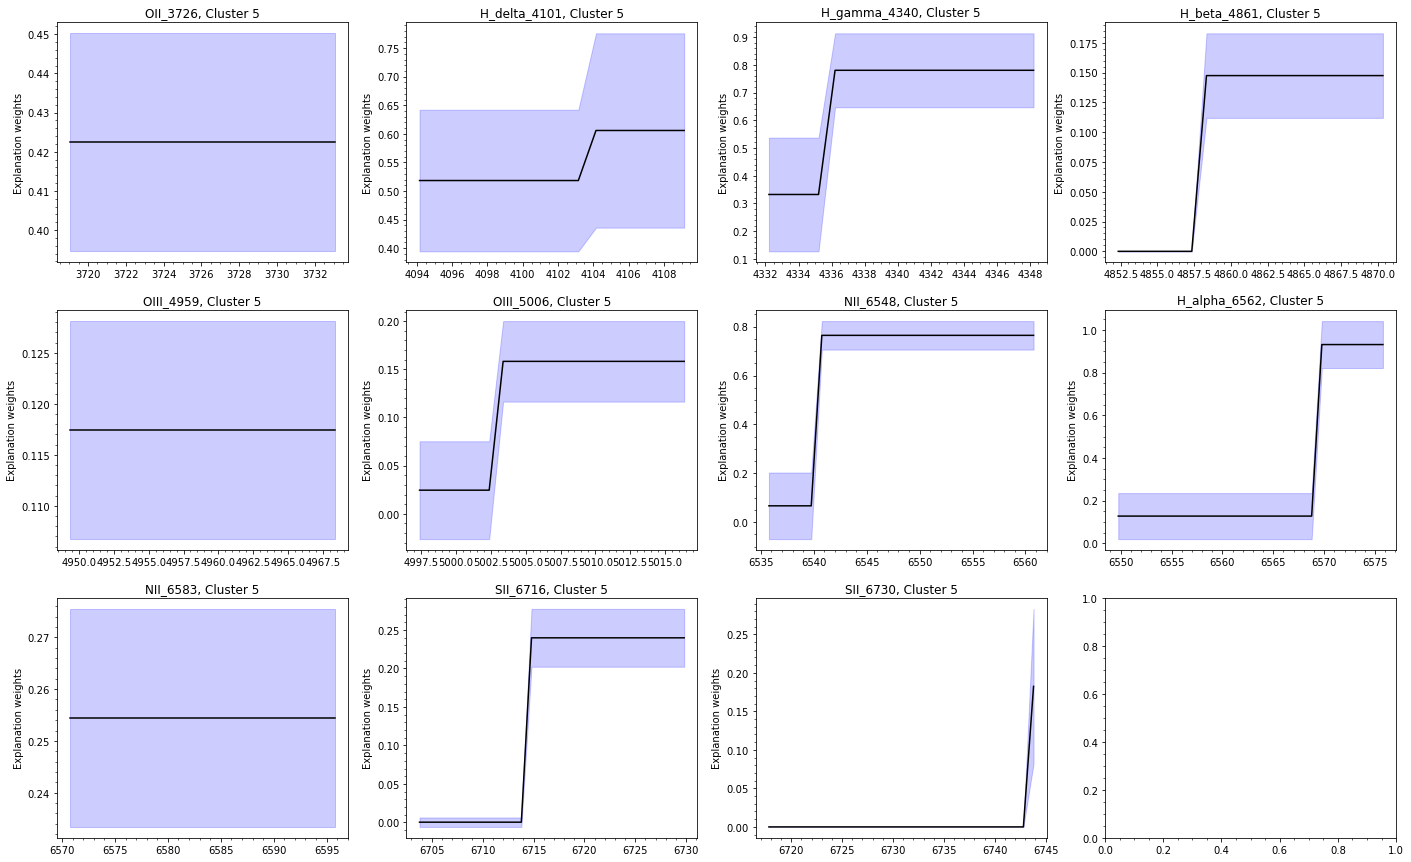

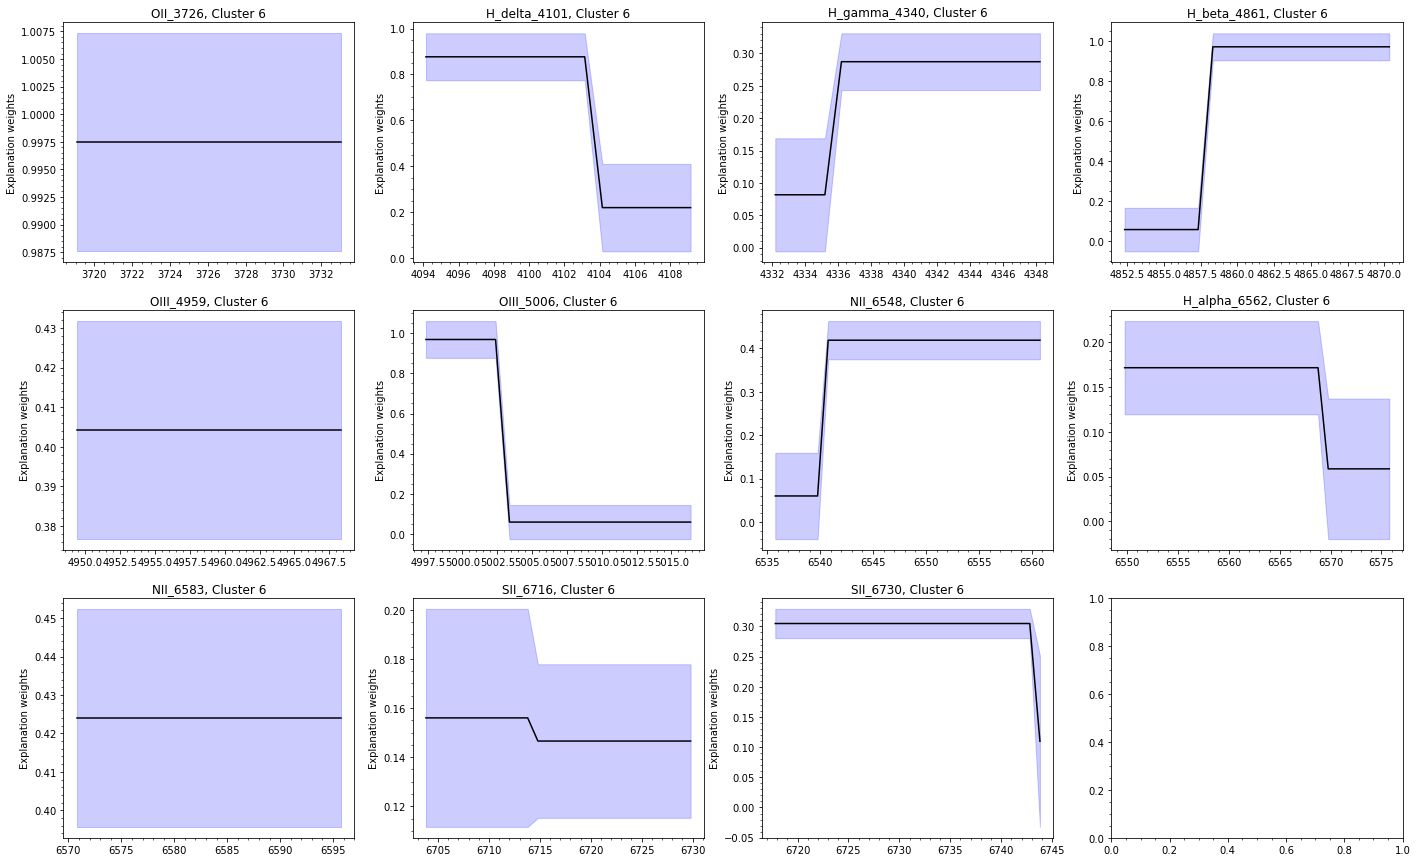

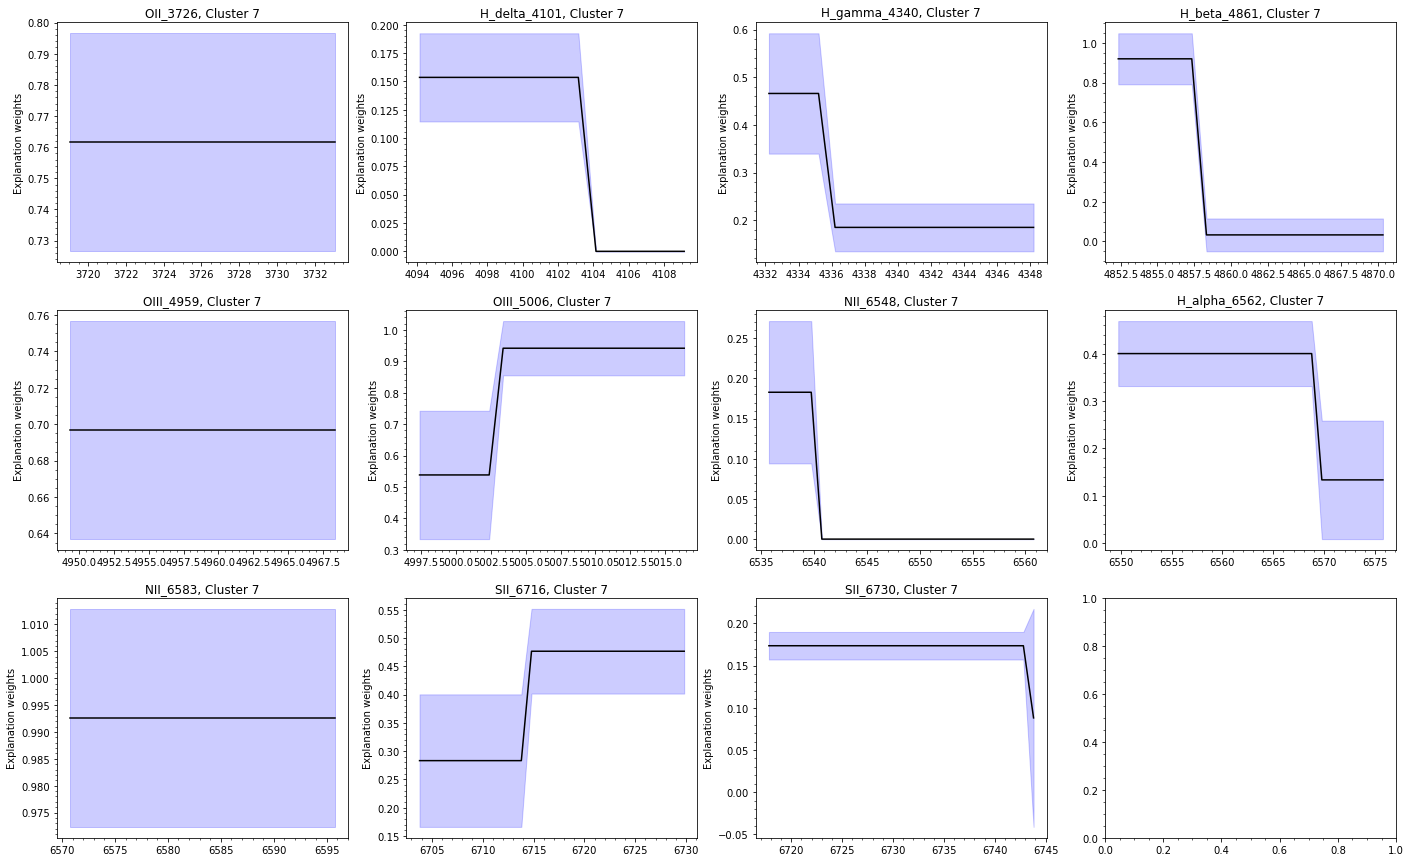

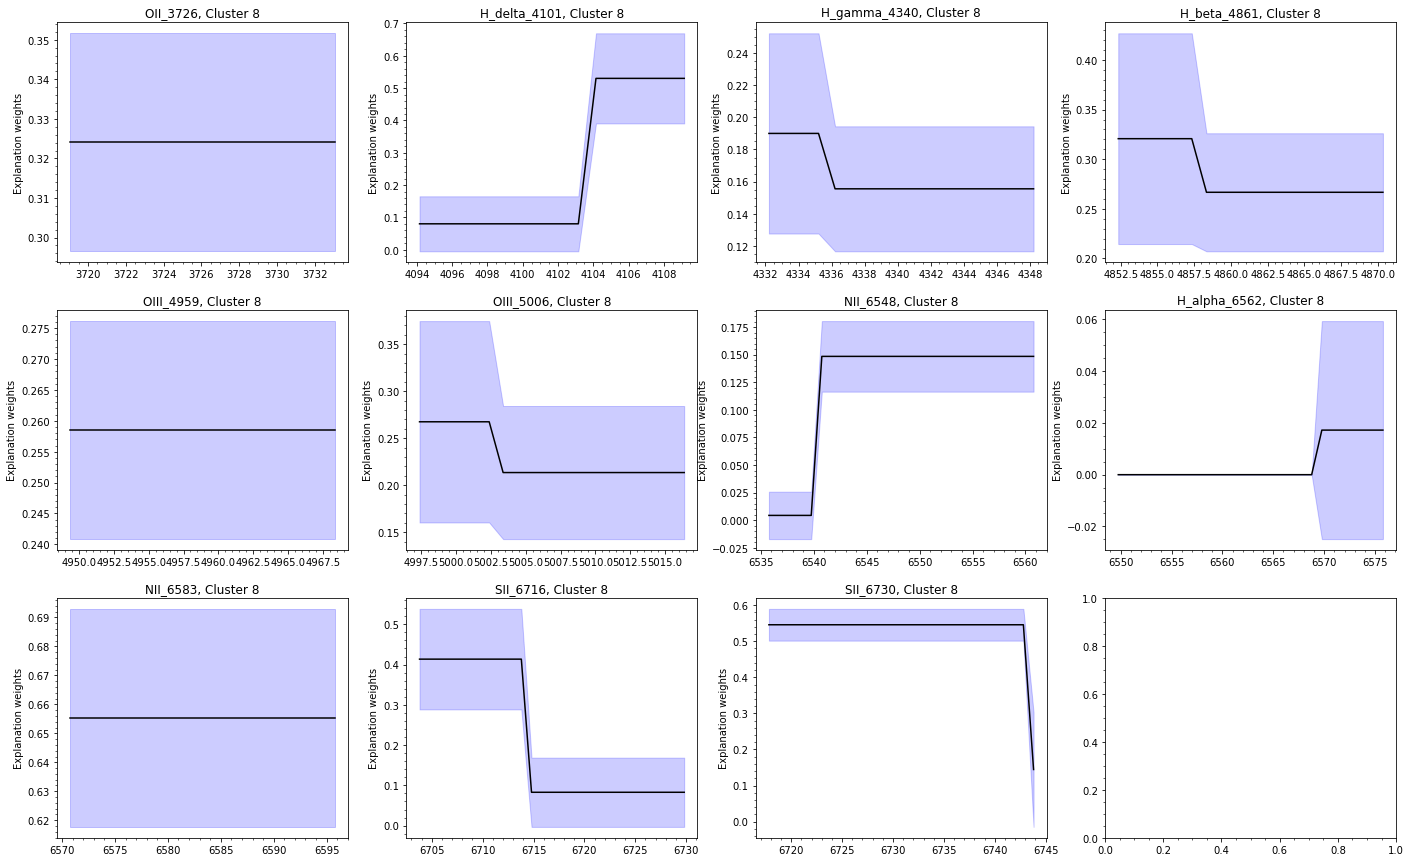

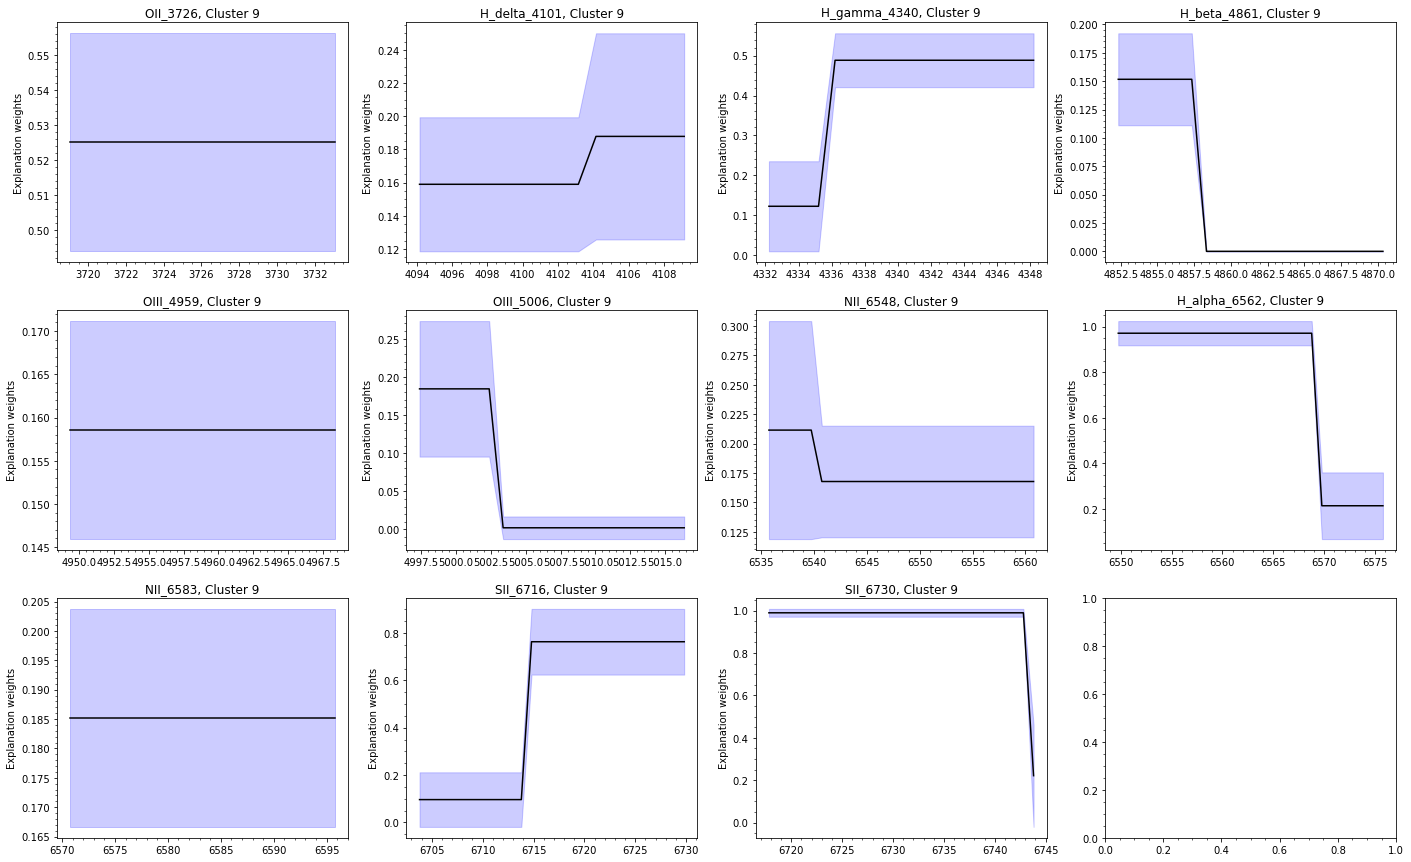

In [42]:
# Set up a figure and axis grid for each cluster
figs, axs = [], []
for c in range(n_clusters):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(24, 15))

    for a in ax.flat:
        a.minorticks_on()

    figs.append(fig)
    axs.append(ax)

# Loop through each line in the dictionary of k-means models
for i, (line, (kmeans, line_mask)) in enumerate(kmeans_per_line.items()):
    # Get the cluster labels for the current line
    cluster_labels = kmeans.predict(line_weights[line][0])

    # Compute the mean and standard deviation of the weights and anomalies for each cluster
    mean_weights = []
    std_weights = []

    for j in range(n_clusters):
        mask = cluster_labels == j
        mean_weights.append(np.mean(line_weights[line][0][mask], axis=0))
        std_weights.append(np.std(line_weights[line][0][mask], axis=0))
    
    # Plot the mean explanation weights for each cluster
    wave_region = wave[line_mask]
    for j in range(n_clusters):
        axs[j][i // 4][i % 4].plot(wave_region, mean_weights[j], c='black')
        axs[j][i // 4][i % 4].set_ylabel('Explanation weights')
        axs[j][i // 4][i % 4].set_title(f'{line}, Cluster {j}')
        axs[j][i // 4][i % 4].fill_between(
            wave_region,
            mean_weights[j] - std_weights[j],
            mean_weights[j] + std_weights[j],
            alpha=0.2,
            color='blue'
        )
